# Spot-checking inicial: Árvore de Decisão

As árvores de decisão são conhecidas por possuírem um baixo viés, ao mesmo tempo em que apresentam alta variância.
Isto é, o método é capaz de modelar fronteiras de decisão bastante complexas, o que, por um lado, é positivo, mas torna o algoritmo bastante suscetível a ruído ou a padrões nos dados de treino que não generalizam para instâncias de teste.
Por isso, técnicas de poda são fundamentais para o uso efetivo do modelo em dados novos.

Nessa atividade, iremos analisar como a estrutura e as predições da árvore de decisão são afetadas por pequenas variações no conjunto de treino. Além disso, veremos duas técnicas de poda que podem ser usadas para controlar a complexidade do modelo.

## Carregamento dos Dados

### Obtenção e análise dos dados
O código abaixo carrega o dataset utilizando as funções do scikit-learn e mostra algumas informações básicas sobre os dados

In [13]:
import pandas as pd

In [14]:
df_sinan_processed = pd.read_csv("../data/processed/2021_part_1.csv")

In [15]:
# Matriz de atributos
X = df_sinan_processed.drop("severity", axis=1)

# Vetor alvo
y = df_sinan_processed["severity"]

feature_names = X.columns.tolist()
target_names = ["low_risk", "alarm", "severe"]

In [16]:
# Codificação dos atributos categóricos com LabelEncoder
from sklearn.preprocessing import LabelEncoder

categorical_attrs = ['sigla_uf_residencia', 'sexo_paciente']

for attr in categorical_attrs:
    le = LabelEncoder()
    X[attr] = le.fit_transform(X[attr])

In [17]:
# Mapeamento dos rótulos alvo para inteiros (por conveniência)

target_mapping = {
    name: idx for idx, name in enumerate(target_names)
}
target_mapping_reverse = {
    idx: name for idx, name in enumerate(target_names)
}

y = y.map(target_mapping)

In [19]:
from collections import Counter 

# Contagem do número de exemplos em cada classe
class_counts = Counter(y)
for cls, count in class_counts.items():
    print(f"Número de exemplos na classe '{cls}' ({target_mapping_reverse[cls]}): {count}")

Número de exemplos na classe '0' (low_risk): 420845
Número de exemplos na classe '1' (alarm): 4510
Número de exemplos na classe '2' (severe): 507


## Variância nas Árvores de Decisão


### Analisando a Estrutura das Árvores de Decisão


Como estudado em aula, a árvore de decisão é conhecida por ser um classificador com alta variância. Isso possui consequências na estrutura das árvores treinadas.

O código abaixo treina várias árvores de decisão com diferentes conjuntos de treino obtidos através do método holdout.


In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

def get_root_node(dt, feature_names):
    feature_idx = dt.tree_.feature[0]
    return feature_names[feature_idx]

n_repeats = 5
root_nodes = []

# Variando o seed do holdout, geramos diferentes conjuntos de treino/teste
for split_random_state in range(0, n_repeats):
  # Holdout com 20% de teste
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=split_random_state)

  # Treinamento da árvore de decisão
  dt = DecisionTreeClassifier(random_state=0)
  dt.fit(X_train, y_train)

  # Obtemos o atributo usado na raiz e o salvamos na lista
  root_node = get_root_node(dt, feature_names)
  root_nodes.append(root_node)

root_nodes

['apresenta_leucopenia',
 'apresenta_leucopenia',
 'apresenta_leucopenia',
 'apresenta_leucopenia',
 'apresenta_leucopenia']

### Analisando a Acurácia das Árvores de Decisão

A propriedade de variância também implica em efeitos na variabilidade da performance dos modelos.
Podemos usar a acurácia como medida de performance, o que pode ser feito também através do scikit-learn. Posteriormente estudaremos outras métricas de desempenho que são mais indicadas para problemas em que o número de instâncias por classe é desbalanceado, como é o caso deste conjunto de dados.

In [22]:
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Acurácia nos dados de teste: %.3f" % accuracy)

Acurácia nos dados de teste: 0.979


O código abaixo executa repetidas vezes o treinamento das árvores de decisão, da mesma forma que no item *Analisando a Estrutura das Árvores de Decisão*.

**Atenção: Não mude os valores que estão sendo passados para os parâmetros random_state para garantir a reprodutibilidade do código**.


In [23]:
import numpy as np

accuracies = []

for split_random_state in range(0, n_repeats):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=split_random_state)

  dt = DecisionTreeClassifier(random_state=0)
  
  dt.fit(X_train, y_train)

  # Avaliação da acurácia nos dados de teste
  y_pred = dt.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  accuracies.append(accuracy)

# Cálculo das estatísticas descritivas
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)
max_accuracy = np.max(accuracies)
min_accuracy = np.min(accuracies)

print(f"Acurácia média: {mean_accuracy:.3f}")
print(f"Desvio padrão: {std_accuracy:.3f}")
print(f"Acurácia máxima: {max_accuracy:.3f}")
print(f"Acurácia mínima: {min_accuracy:.3f}")


Acurácia média: 0.981
Desvio padrão: 0.001
Acurácia máxima: 0.981
Acurácia mínima: 0.980


## Observando o Efeito da Poda

As árvores de decisão treinadas nos itens anteriores não possuíam nenhuma forma de poda. No entanto, é possível utilizar técnicas de poda através do scikit-learn. Como consequência, elas podem ter uma complexidade além do que é necessário na modelagem do problema.



### Exemplo de Pré-poda: profundidade máxima da árvore
Podemos especificar a profundidade máxima da árvore utilizando o hiperparâmetro max_depth. Veja como exemplo o código abaixo.

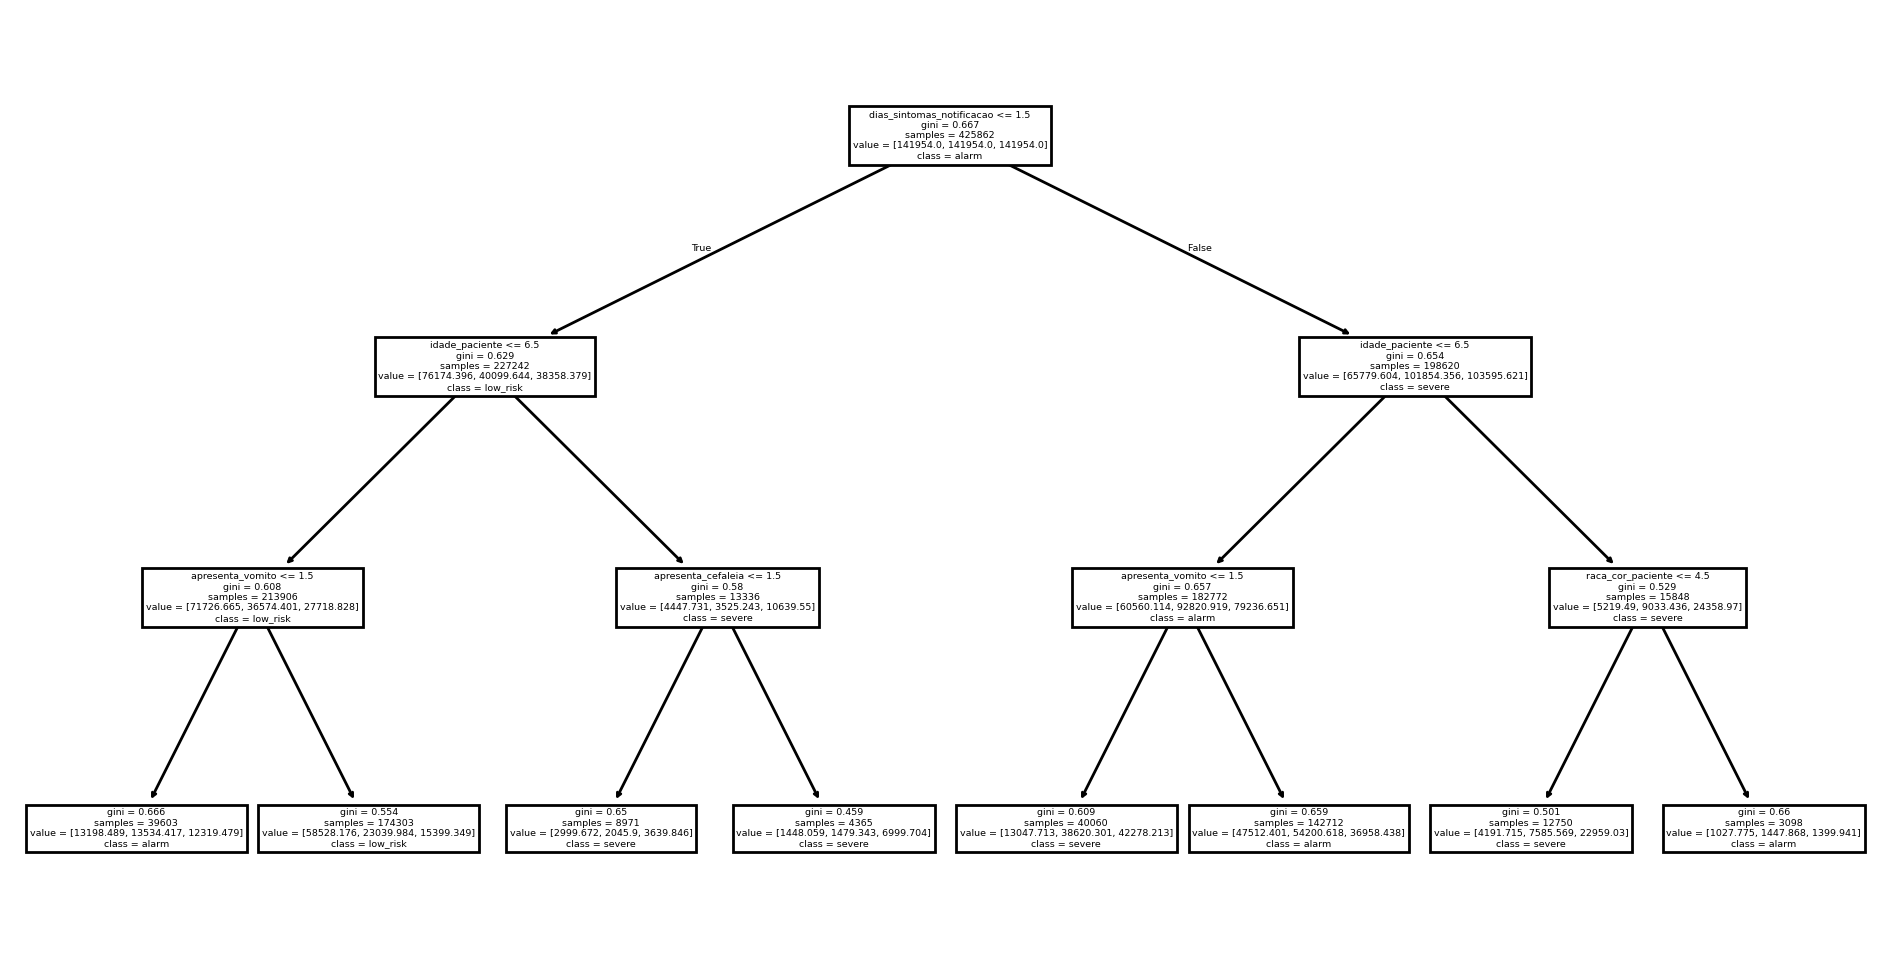

In [103]:
import matplotlib.pyplot as plt

dt = DecisionTreeClassifier(max_depth=3, class_weight='balanced')
dt.fit(X, y)

from sklearn.tree import plot_tree
plt.figure(figsize=(12,6), dpi=200)
_ = plot_tree(dt, feature_names=feature_names, class_names=target_names)

O código abaixo gera árvores de decisão com diferentes profundidades máximas e as avalia em termos de acurácia.

Observe que todas as árvores são treinadas e avaliadas com os mesmos conjuntos de treino, validação e teste, visto que especificamos o parâmetro $random\_state = 42$.

Com base nesse código, e possíveis modificações que você faça a ele, responda à Questão  4 do questionário.

**Não mude o valor que está sendo passado em random_state**.


In [25]:
# Definindo as proporções de treino, validação e teste.
train_ratio = 0.70
test_ratio = 0.15
validation_ratio = 0.15

# Fazendo a primeira divisão, para separar um conjunto de teste dos demais.
# Assuma X_temp e y_temp para os dados de treinamento+validação e X_test e y_test para os de teste

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=test_ratio, random_state=42, stratify=y)

# Fazendo a segunda divisão, para gerar o conjunto de treino e validação a partir
# do conjunto de 'treinamento' da divisão anterior
# Assuma X_train e y_train para os dados de treinamento e X_valid e y_valid para os de teste

X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=validation_ratio/(train_ratio+test_ratio), random_state=42, stratify=y_temp)

print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)

(298102, 26)
(63880, 26)
(63880, 26)


In [26]:
from imblearn.over_sampling import SMOTE
from collections import Counter

print("Distribuição original do treino:", Counter(y_train))

smote = SMOTE(random_state=42)

# Aplique o SMOTE apenas nos dados de treino
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Distribuição do treino após SMOTE:", Counter(y_train_resampled))

Distribuição original do treino: Counter({0: 294590, 1: 3157, 2: 355})
Distribuição do treino após SMOTE: Counter({0: 294590, 2: 294590, 1: 294590})


In [27]:
max_depths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, None]
accuracies_valid = []
accuracies_train = []

for depth in max_depths:
  dt = DecisionTreeClassifier(max_depth=depth, random_state=0)
  dt.fit(X_train_resampled, y_train_resampled) # Usando os dados balanceados com SMOTE

  y_pred = dt.predict(X_valid)
  acc = accuracy_score(y_valid, y_pred)
  accuracies_valid.append(acc)
  accuracies_train.append(dt.score(X_train, y_train))

In [28]:
accuracies_valid

[0.7919223544145272,
 0.7547432686286788,
 0.7313556668753913,
 0.6932999373825923,
 0.7492329367564183,
 0.7299467752035066,
 0.7449279899812148,
 0.7529273638071384,
 0.760472761427677,
 0.7584376956793989,
 0.6698497182216656,
 0.7104884157795868,
 0.8847996242955541]

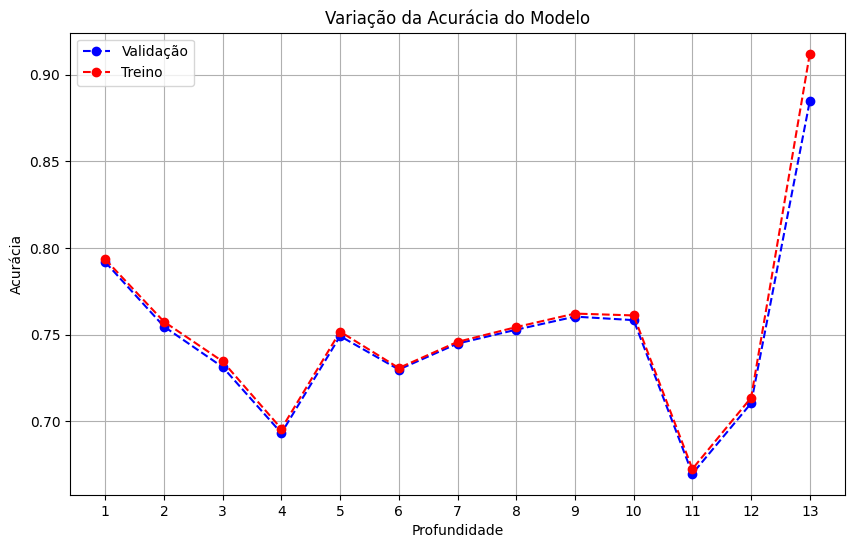

In [ ]:
# Plotar a variação das acurácias
plt.figure(figsize=(10,6))
plt.plot(range(1, len(max_depths)+1), accuracies_valid, marker='o', linestyle='--', color='b', label='Validação')
plt.plot(range(1, len(max_depths)+1), accuracies_train, marker='o', linestyle='--', color='r', label='Treino')
plt.title('Variação da Acurácia do Modelo')
plt.xlabel('Profundidade')
plt.ylabel('Acurácia')
plt.xticks(range(1, len(max_depths)+1))
plt.legend()
plt.grid(True)
plt.show()

Para avaliarmos o desempenho do modelo otimizado em novos dados, devemos repetir o treinamento selecionando o melhor valor de hiperparâmetro(s) com base no gráfico anterior, e fazer a avaliação nos dados de teste.
Para melhorar a capacidade de estimar o desempenho do modelo, podemos treinar com os dados de treinamento e validação, tendo em vista que ambos são independentes do conjunto de teste (dados nunca vistos).


In [30]:
best_max_depth = 13 # preencha aqui com o melhor valor do hiperparâmetros, conforme análise anterior

In [31]:
# concatena dados de treino e validação, para treinar modelo a ser avaliado com dados de teste
X_train2 = np.concatenate((X_train, X_valid), axis=0)
y_train2 = np.concatenate((y_train, y_valid), axis=0)

In [32]:
smote_final = SMOTE(random_state=42)
X_train_final, y_train_final = smote_final.fit_resample(X_train2, y_train2)

In [33]:
print("Distribuição após SMOTE final:", Counter(y_train_final))

Distribuição após SMOTE final: Counter({np.int64(0): 357718, np.int64(2): 357718, np.int64(1): 357718})


In [34]:
# treina e avalia a árvore de decisão com valor otimizado de max_depth
dt = DecisionTreeClassifier(max_depth=best_max_depth, random_state=0)
dt.fit(X_train_final, y_train_final)

y_pred = dt.predict(X_test)
acc = accuracy_score(y_test, y_pred)
acc

/home/gabriel/Documents/UFRGS/2025-2/ML/TF/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


0.7452410770194114

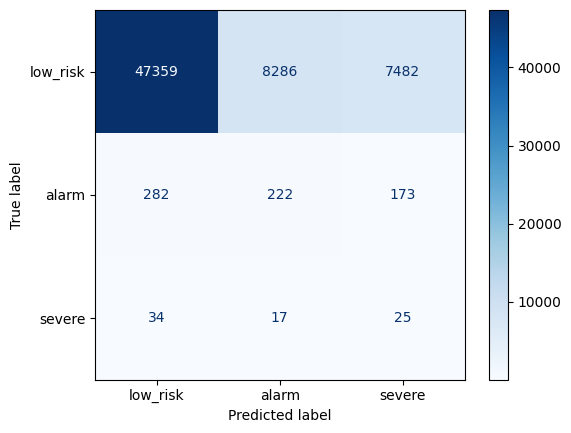

In [35]:
# Plota a matriz de confusão
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=target_names, cmap=plt.cm.Blues)

SMOTE não é a ferramenta ideal para trabalhar com o nosso dataset. A matriz de confusão deixa isso bastante evidente, visto que o número de falsos negativos em instâncias da classe "severe", o qual é um valor que **deve** ser minimizado, é bastante alto (mais alto que o número de verdadeiros positivos). Isso se deve ao fato de o número de exemplos dessa classe ser pequeno demais, em relação ao número total de exemplos do dataset, para aplicar apenas o SMOTE padrão.

A seguir, testamos uma técnica que combina SMOTE (oversampling) com undersampling.

In [182]:
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTEN
from collections import Counter

print("Distribuição original do treino:", Counter(y_train))

# Step 1: Define the undersampling strategy
under_sampler = RandomUnderSampler(
    sampling_strategy={0: 50000},
    random_state=42
)

# Step 2: Define the oversampling strategy
over_sampler = SMOTEN(
    sampling_strategy={1: 20000, 2: 10000},
    random_state=42
)

# Step 3: Create the pipeline
# IMPORTANT: The pipeline runs in order. Undersampling first, then oversampling
pipeline = Pipeline([
    ('under', under_sampler),
    ('over', over_sampler)
])

X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train, y_train)

print("Distribuição do treino após resampling:", Counter(y_train_resampled))

Distribuição original do treino: Counter({0: 294590, 1: 3157, 2: 355})
Distribuição do treino após resampling: Counter({0: 50000, 1: 20000, 2: 10000})


In [183]:
# Use F1-macro to select the best max_depth
from sklearn.metrics import f1_score

max_depths = list(range(1, 31)) + [None]
accuracies_valid = []
accuracies_train = []
f1_scores_valid = []
f1_scores_train = []

for depth in max_depths:
  dt = DecisionTreeClassifier(max_depth=depth, criterion='entropy', class_weight='balanced', random_state=0)
  dt.fit(X_train_resampled, y_train_resampled) # Usando os dados balanceados com SMOTE

  y_pred = dt.predict(X_valid)

  acc = accuracy_score(y_valid, y_pred)
  accuracies_valid.append(acc)
  accuracies_train.append(dt.score(X_train, y_train))

  f1_valid = f1_score(y_valid, y_pred, average='macro', zero_division=0)
  f1_scores_valid.append(f1_valid)

  y_pred_train = dt.predict(X_train)
  f1_train = f1_score(y_train, y_pred_train, average='macro', zero_division=0)
  f1_scores_train.append(f1_train)


In [184]:
# accuracies_valid
f1_scores_valid

[0.3479351338191965,
 0.33745502010593104,
 0.30147667521866167,
 0.31041213304457693,
 0.2833608918735462,
 0.3030701377654382,
 0.3019818010322905,
 0.2548683150883284,
 0.27052618234372,
 0.2730146514755783,
 0.29252285205227985,
 0.2873125628281162,
 0.28616582067040486,
 0.29440658799831276,
 0.3019206960598184,
 0.302771491094331,
 0.3061693099113321,
 0.3091087330159315,
 0.31169179025608307,
 0.3144665380035,
 0.3142255291213691,
 0.3178978284789827,
 0.3202132507484299,
 0.3196571645921968,
 0.3202451818870517,
 0.3203956351719289,
 0.3208975004224349,
 0.3209265535037605,
 0.3206549939249292,
 0.3207690607065106,
 0.3207876911797529]

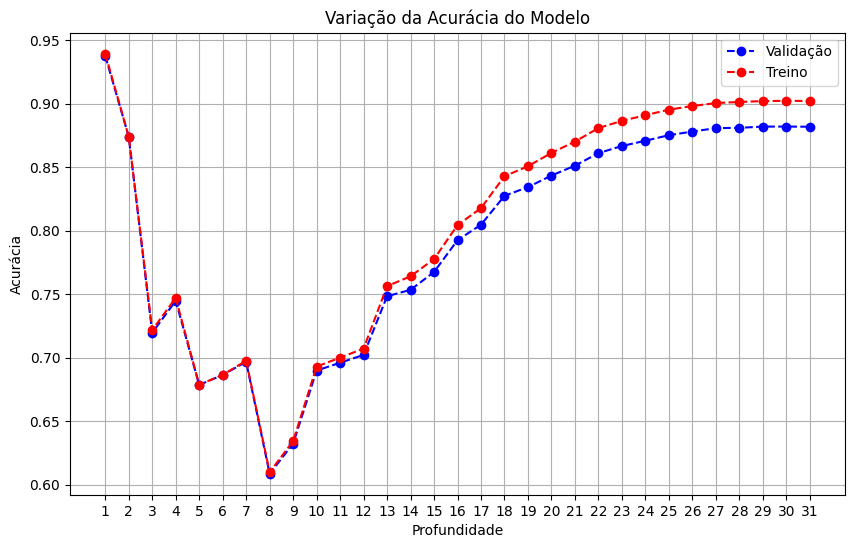

In [172]:
# Plotar a variação das acurácias
plt.figure(figsize=(10,6))
plt.plot(range(1, len(max_depths)+1), accuracies_valid, marker='o', linestyle='--', color='b', label='Validação')
plt.plot(range(1, len(max_depths)+1), accuracies_train, marker='o', linestyle='--', color='r', label='Treino')
plt.title('Variação da Acurácia do Modelo')
plt.xlabel('Profundidade')
plt.ylabel('Acurácia')
plt.xticks(range(1, len(max_depths)+1))
plt.legend()
plt.grid(True)
plt.show()

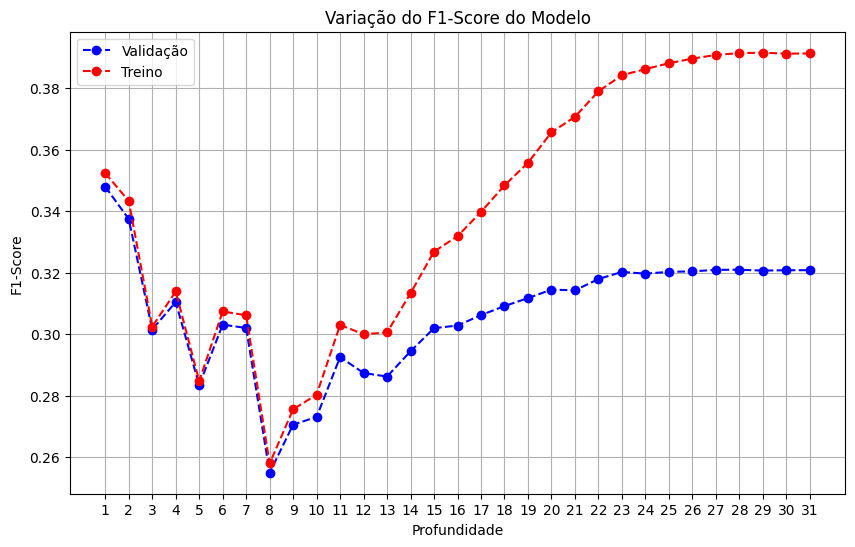

In [185]:
# Plotar a variação dos F1-scores
plt.figure(figsize=(10,6))
plt.plot(range(1, len(max_depths)+1), f1_scores_valid, marker='o', linestyle='--', color='b', label='Validação')
plt.plot(range(1, len(max_depths)+1), f1_scores_train, marker='o', linestyle='--', color='r', label='Treino')
plt.title('Variação do F1-Score do Modelo')
plt.xlabel('Profundidade')
plt.ylabel('F1-Score')
plt.xticks(range(1, len(max_depths)+1))
plt.legend()
plt.grid(True)
plt.show()

In [186]:
best_max_depth = 7 # preencha aqui com o melhor valor do hiperparâmetros, conforme análise anterior

In [188]:
# concatena dados de treino e validação, para treinar modelo a ser avaliado com dados de teste
X_train2 = np.concatenate((X_train, X_valid), axis=0)
y_train2 = np.concatenate((y_train, y_valid), axis=0)

In [189]:
# Step 1: Define the undersampling strategy
under_sampler_final = RandomUnderSampler(
    sampling_strategy={0: 50000},
    random_state=42
)

# Step 2: Define the oversampling strategy
over_sampler_final = SMOTEN(
    sampling_strategy={1: 20000, 2: 10000},
    random_state=42
)
pipeline_final = Pipeline([
    ('under', under_sampler_final),
    ('over', over_sampler_final)
])

X_train_final, y_train_final = pipeline_final.fit_resample(X_train2, y_train2)

In [190]:
dt = DecisionTreeClassifier(max_depth=best_max_depth, criterion='entropy', class_weight='balanced', random_state=0)
dt.fit(X_train_final, y_train_final)

y_pred = dt.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
print(f"Accuracy: {acc:.3f}")
print(f"F1-macro: {f1:.3f}")

Accuracy: 0.740
F1-macro: 0.305


/home/gabriel/Documents/UFRGS/2025-2/ML/TF/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


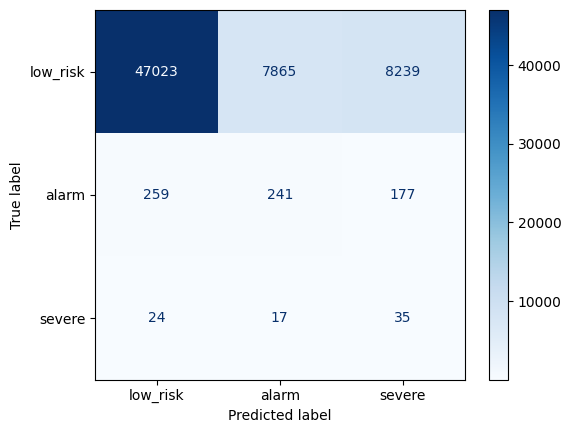

In [191]:
# Plota a matriz de confusão
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=target_names, cmap=plt.cm.Blues)

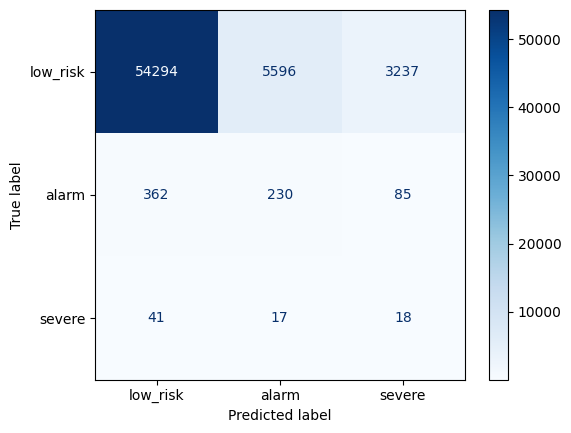

In [47]:
# Plota a matriz de confusão
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=target_names, cmap=plt.cm.Blues)